# Finding Nuisance flood elevations and corresponsding buildings with 'wet feet' in VA Beach

### import needed modules

In [1]:
%matplotlib inline
import matplotlib as mpl
#mpl.style.use('ggplot')
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from matplotlib import gridspec
from ipywidgets.widgets.interaction import interact, interact_manual

### Define functions needed

In [2]:
def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return idx

def save_figure(path,name):
    plt.savefig(path+name+".png",
                dpi=200,
                facecolor='white',
                edgecolor='white')
    
def ECDF(dataseries):
    sq = dataseries.value_counts()
    ecdf = sq.sort_index().cumsum()*1/len(dataseries)
    return ecdf

def ECDF_FUNC(value, ecdf, mode='getvalue'):
    #Input probability, return value
    if mode == 'getvalue':
        prob_idx = find_nearest(ecdf,1-value)
        nearest_value = (1-ecdf[prob_idx])
        output = [prob_idx,nearest_value]
        #print('A value of {0:3.3f} corresponds to the given exceedance probability of {1:3.2f}%'.format(output,(1-ecdf[prob_idx])*100))
    elif mode == 'getprob':
        value_idx = find_nearest(ecdf.index,value)
        #print(value_idx)
        output = ecdf[ecdf.index[value_idx]]
        exceed_prob = (1-output)*100
        #print('An exceedance probability of {0:.2f}% corresponds to the given value {1:.3f}'.format(exceed_prob,value))
    else:
        print('INPUT ERROR: "mode" must be "getvalue" or "getprob"')
    return output

In [3]:
def get_exceedance_value(data_file,gauge_correction,MHHW2NAVD88,target_exceedance_prob):
    Data = pd.read_csv(data_file, 
                       delimiter=',',
                       usecols=(0,1,2),
                       infer_datetime_format=True,
                       skiprows=0
                      )
    Data.columns = ['datetime','water_level','ty']
    Data['datetime'] = Data['datetime'].apply(pd.to_datetime)
    Data.set_index('datetime', inplace=True)
    df = Data[Data.ty == 'HH'].append(Data[Data.ty == 'H ']).reset_index().sort_values(by='datetime').set_index('datetime')
    #Data.set_index('ty').ix['H ','HH']
    #raw water_level data in ft above MHHW(0.349m or (34.9cm/(2.54*12(cm/ft))) NAVD @ Sewells Point,VA)
    swel_series = df.water_level['1996-01-01':'2000-12-31']+MHHW2NAVD88 #ft NAVD
    ecdf_swel = ECDF(swel_series)
    swel_val = ECDF_FUNC(target_exceedance_prob,ecdf_swel,mode="getvalue")
    tidegauge_swel_val = swel_val[0]*12*2.54/100+gauge_correction
    print('A value of {0:3.3f} ft NAVD corresponds to the given exceedance probability of {1:3.2f}%'.format(swel_val[0],swel_val[1]*100))
    print('This is equivalent to {0:3.3f} meters referenced to the gauge.'.format(tidegauge_swel_val))

In [4]:
def nuisance_flooding(user_input,lag_ecdf,ffe_ecdf):
    title ='FFE vs LAG'
    #Initialize figure and set dimensions
    fig = plt.figure(figsize = (9,9))
    gs = gridspec.GridSpec(2,2)
    ax1 = fig.add_subplot(gs[:,:])
    ax1.set_title(title,fontsize=20)
    #Remove the plot frame lines. They are unnecessary chartjunk.
    ax1.spines["top"].set_visible(False)  
    ax1.spines["right"].set_visible(False) 
    # Ensure that the axis ticks only show up on the bottom and left of the plot.  
    # Ticks on the right and top of the plot are generally unnecessary chartjunk.  
    ax1.get_xaxis().tick_bottom()  
    ax1.get_yaxis().tick_left()  
    # Make sure your axis ticks are large enough to be easily read.  
    # You don't want your viewers squinting to read your plot.  
    ax1.tick_params(axis="both", which="both", bottom="off", top="off",  
                    labelbottom="on", left="on", right="off", labelleft="on",labelsize=14)
    # Along the same vein, make sure your axis labels are large  
    # enough to be easily read as well. Make them slightly larger  
    # than your axis tick labels so they stand out.  
    ax1.set_xlabel("Elevation (ft)", fontsize=16)  
    ax1.set_ylabel("Frequency of occurence", fontsize=16)  
    #set x-axis limits
    ax1.set_xlim(-5,35)
    ax1.set_ylim(0,1)
    #Plot
    ax1.step(lag_ecdf.index,lag_ecdf.values,color='darkorange',linewidth=2)
    ax1.step(ffe_ecdf.index,ffe_ecdf.values,color='purple',linewidth=2)
    #Find %wet vs. %damaged
    SWEL = user_input
    FFE_SWEL = ECDF_FUNC(SWEL, ffe_ecdf, mode="getprob")
    LAG_SWEL = ECDF_FUNC(SWEL, lag_ecdf, mode="getprob")
    x=[SWEL,SWEL]
    y=[FFE_SWEL,LAG_SWEL]
    ax1.vlines(SWEL,0,1,alpha=0.5,color='g',linestyle='dashed',linewidth=2)
    ax1.scatter(x, y, s=50, c='g', alpha=0.9, marker='o')
    print('For a {0:2.2f}ft SWEL, {1:2.3f}% of buildings are wet and {2:2.3f}% of buildings are damaged.'.format(SWEL,LAG_SWEL*100,FFE_SWEL*100))

## Import HAZUS Building Data
Empirical cummulative distributions are then defined to describe the LAG (lowest ajacent grade) elevation and FFE (first floor elevevation) for each building footprint. 

In [5]:
hazus_dir = "/home/user/Documents/recurrence_interval"
hazus_dbf = "HAZUS_BM_Data.dbf"
os.chdir(hazus_dir)
from dataIO import dbf2df, df2dbf
hzsdf = dbf2df(hazus_dbf)
hzsdf.set_index('CensusBloc',inplace=True)
lag_ecdf=ECDF(hzsdf.LAG_ELEV)
ffe_ecdf=ECDF(hzsdf.LAG_ELEV+hzsdf.FFH_RegEq)

## Calculate nuisance flood elevations from NOAA tide gauge data
For convenience 'nuisance' flooding is defined as inundation occuring on an average bi-weekly interval, or 26 events per year. Given that tidal cycles repeat approximately daily this means each day we have a 26 out of 365, or ~7%, probability of flooding at this elevation.  

### Sewells Point: 8638610

In [7]:
working_dir = r"/home/user/Documents/recurrence_interval/NOAA_Data/8638610/high_low"
os.chdir(working_dir)  
data_file = '8638610_hl.csv'
gauge_correction       = 1.827 #meters    
target_exceedance_prob = 0.07
MHHW2NAVD88            = 34.9/(2.54*12)
get_exceedance_value(data_file=data_file,gauge_correction=gauge_correction,MHHW2NAVD88=MHHW2NAVD88,target_exceedance_prob=target_exceedance_prob)

A value of 2.062 ft NAVD corresponds to the given exceedance probability of 7.03%
This is equivalent to 2.456 meters referenced to the gauge.


With the calculated nuisance flooding elevation (NFE) the percent of all building footprints which are wetted ($LAG < NFE$) and damaged ($NFE > FFE$) can be calculated using the defined empirical CDFs.

For a 2.06ft SWEL, 0.250% of buildings are wet and 0.175% of buildings are damaged.


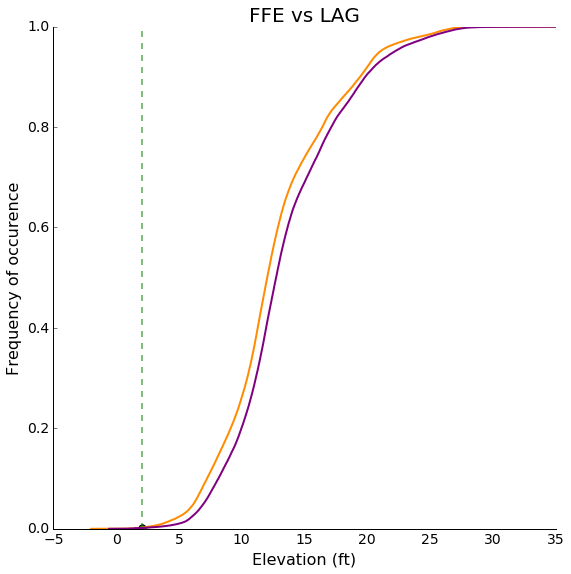

In [8]:
nuisance_flooding(2.062,lag_ecdf,ffe_ecdf)

In [9]:
number_buildings = len(hzsdf)
number_wet_bl = 0.00250*number_buildings
number_damaged_bl = 0.00175*number_buildings
print('Given the total number of buildings, {0:.0f}, this means ~{1:.0f} are wet and ~{2:.0f} are damaged in the baseline scenario.'.format(number_buildings,number_wet_bl, number_damaged_bl)) 

Given the total number of buildings, 150119, this means ~375 are wet and ~263 are damaged in the baseline scenario.


## Future scenarios (+1.5 and +3.0 feet)
Considering what this level of nuisance flooding will mean in the future with added sea level rise can be accomplished by making the that SLR will not affect frequent water level events in a non-linear fashion. This assumption agrees well with what was seen in North Carolina during the XXXX study conducted by Dewberry. With this assumption in place we can then the future nuisance flood elevations simply by adding SLR to the existing NFE. This result in values of 3.562ft and 5.062ft. Plugging these numbers back into the empirical CDFs of the building LAG and FFE data gives the results. 

For a 3.56ft SWEL, 0.921% of buildings are wet and 0.446% of buildings are damaged.


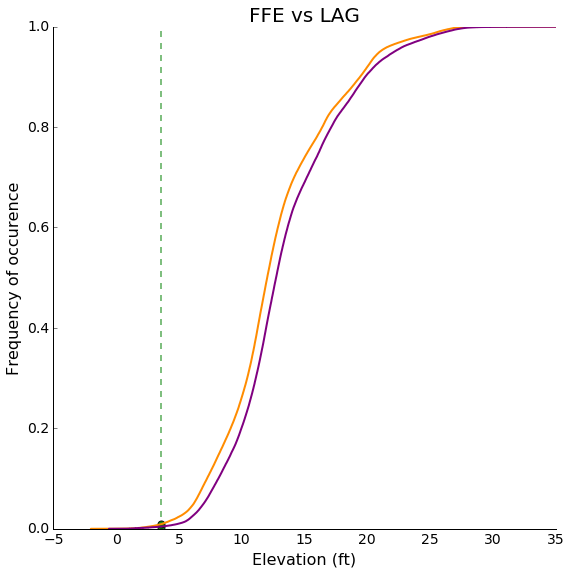

In [10]:
nuisance_flooding(3.562,lag_ecdf,ffe_ecdf)

In [11]:
number_wet_bl = 0.00921*number_buildings
number_damaged_bl = 0.00446*number_buildings
print('Given the total number of buildings, {0:.0f}, this means ~{1:.0f} are wet and ~{2:.0f} are damaged in the 1.5ft SLR scenario.'.format(number_buildings,number_wet_bl, number_damaged_bl)) 

Given the total number of buildings, 150119, this means ~1383 are wet and ~670 are damaged in the 1.5ft SLR scenario.


For a 5.06ft SWEL, 2.499% of buildings are wet and 1.085% of buildings are damaged.


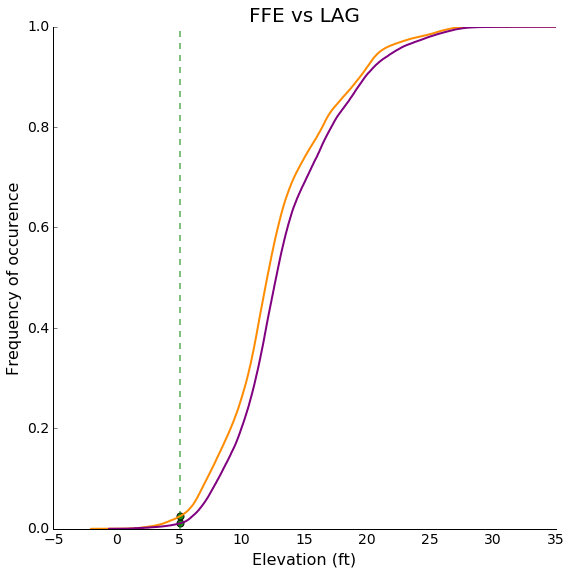

In [12]:
nuisance_flooding(5.062,lag_ecdf,ffe_ecdf)

In [13]:
number_wet_bl = 0.02499*number_buildings
number_damaged_bl = 0.01085*number_buildings
print('Given the total number of buildings, {0:.0f}, this means ~{1:.0f} are wet and ~{2:.0f} are damaged in the 3.0ft SLR scenario.'.format(number_buildings,number_wet_bl, number_damaged_bl)) 

Given the total number of buildings, 150119, this means ~3751 are wet and ~1629 are damaged in the 3.0ft SLR scenario.


### Chesapeake Bay Bridge Tunnel: 8638863

In [11]:
working_dir = r"/media/sf_Shared_Linux/recurrence_interval/NOAA_Data/8638863/high_low"
os.chdir(working_dir) 
data_file = '8638863_hl.csv'
gauge_correction = 0.0 #meters    
target_exceedance_prob = 0.07
get_exceedance_value(data_file=data_file,gauge_correction=gauge_correction,target_exceedance_prob=target_exceedance_prob)

A value of 2.076 ft NAVD corresponds to the given exceedance probability of 7.00%
This is equivalent to 0.633 meters referenced to the gauge.


### Duck, NC: 8651370

In [12]:
working_dir = r"/media/sf_Shared_Linux/recurrence_interval/NOAA_Data/8651370/high_low"
os.chdir(working_dir) 
data_file = '8651370_hl.csv'
gauge_correction = 6.330696 #meters    
target_exceedance_prob = 0.07
get_exceedance_value(data_file=data_file,gauge_correction=gauge_correction,target_exceedance_prob=target_exceedance_prob)

A value of 2.089 ft NAVD corresponds to the given exceedance probability of 7.02%
This is equivalent to 6.967 meters referenced to the gauge.


### Oregon Inlet Marina, NC: 8652587

In [13]:
working_dir = r"/media/sf_Shared_Linux/recurrence_interval/NOAA_Data/8652587/high_low"
os.chdir(working_dir) 
data_file = '8652587_hl.csv'
gauge_correction = 1.002792 #meters    
target_exceedance_prob = 0.07
get_exceedance_value(data_file=data_file,gauge_correction=gauge_correction,target_exceedance_prob=target_exceedance_prob)

A value of 1.808 ft NAVD corresponds to the given exceedance probability of 7.04%
This is equivalent to 1.554 meters referenced to the gauge.


## Finding Nuisance Flooding

### Import HAZUS building footprint data

In [ ]:
interact_manual(nuisance_flooding,user_input=[-5,35,0.05])